In [1]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import normalize
from pybrain.datasets import ClassificationDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError
import xgboost as xgb
%matplotlib inline

## Цель вычислительного эксперимента

Необходимо решить задачу классификации

## Описание выборок

Задача должна решаться на двух выборках: синтетическая и https://archive.ics.uci.edu/ml/datasets/Breast+Cancer

Во второй выборке представлены медицинские описания онкобольных с заболеванием рака груди, также указано, произошел ли рецидив заболевания. Так как я не являюсь практикующим врачом-онкологом, генерация синтетической выборки, приближенной ко второй выборке, мне не представляется осуществимой. Соответственно, буду решать задачу на двух принципиально **различных выборках**.

# Синтетическая выборка

## Цель вычислительного эксперимента

По данным коэффициентам полинома 7 порядка и точке координатной прямой из интервала [-1, 1] необходимо определить является ли значение полинома в точке больше 0 или нет.

## Описание выборки

Выбираются случайная точка координатной прямой и случайные коэффициенты полинома, в этой точке вычисляется значение полинома. Соответственно, определяется класс, в которому принадлежит данный объект. Затем к признакам добавляется шум, а класс меняется на противоположный с вероятностью $p = 0.01$. Размер выборки — 1000 элементов.

In [2]:
X = 2 * np.random.random((1000, 9)) - 1
Y = np.zeros((1000, ))
t = np.ones((1000, ))
for i in range(8):
    Y = Y + t * X[:, i + 1]
    t = t * X[:, 0]
Y = (Y > 0).astype(int)

In [3]:
X = X + np.random.normal(0, 0.1, (1000, 9))
Y = (Y + (np.random.random((1000, )) < 0.01).astype(int)) % 2

In [4]:
data = pd.DataFrame(np.concatenate((X, Y.reshape(1000, 1)), axis=1), columns=['x', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'y'], dtype=float)


In [5]:
data.head(3)

,x,C0,C1,C2,C3,C4,C5,C6,C7,y
0,0.917360,0.104630,-0.097148,-0.572390,-1.010731,0.656578,-0.015781,-0.651590,0.500327,0.0
1,-0.582251,0.381840,0.841658,0.950322,-0.645305,0.998993,0.337468,0.750124,0.534745,1.0
2,0.720327,0.275342,-0.335728,0.411348,-0.022605,-0.682851,0.400984,0.687551,0.462387,1.0


Для данной синтетической выборки предобработка не требуется.

## Анализ состава выборки

Анализ пропусков выполнять не нужно, т.к. выборка строилась без них

E:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
E:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


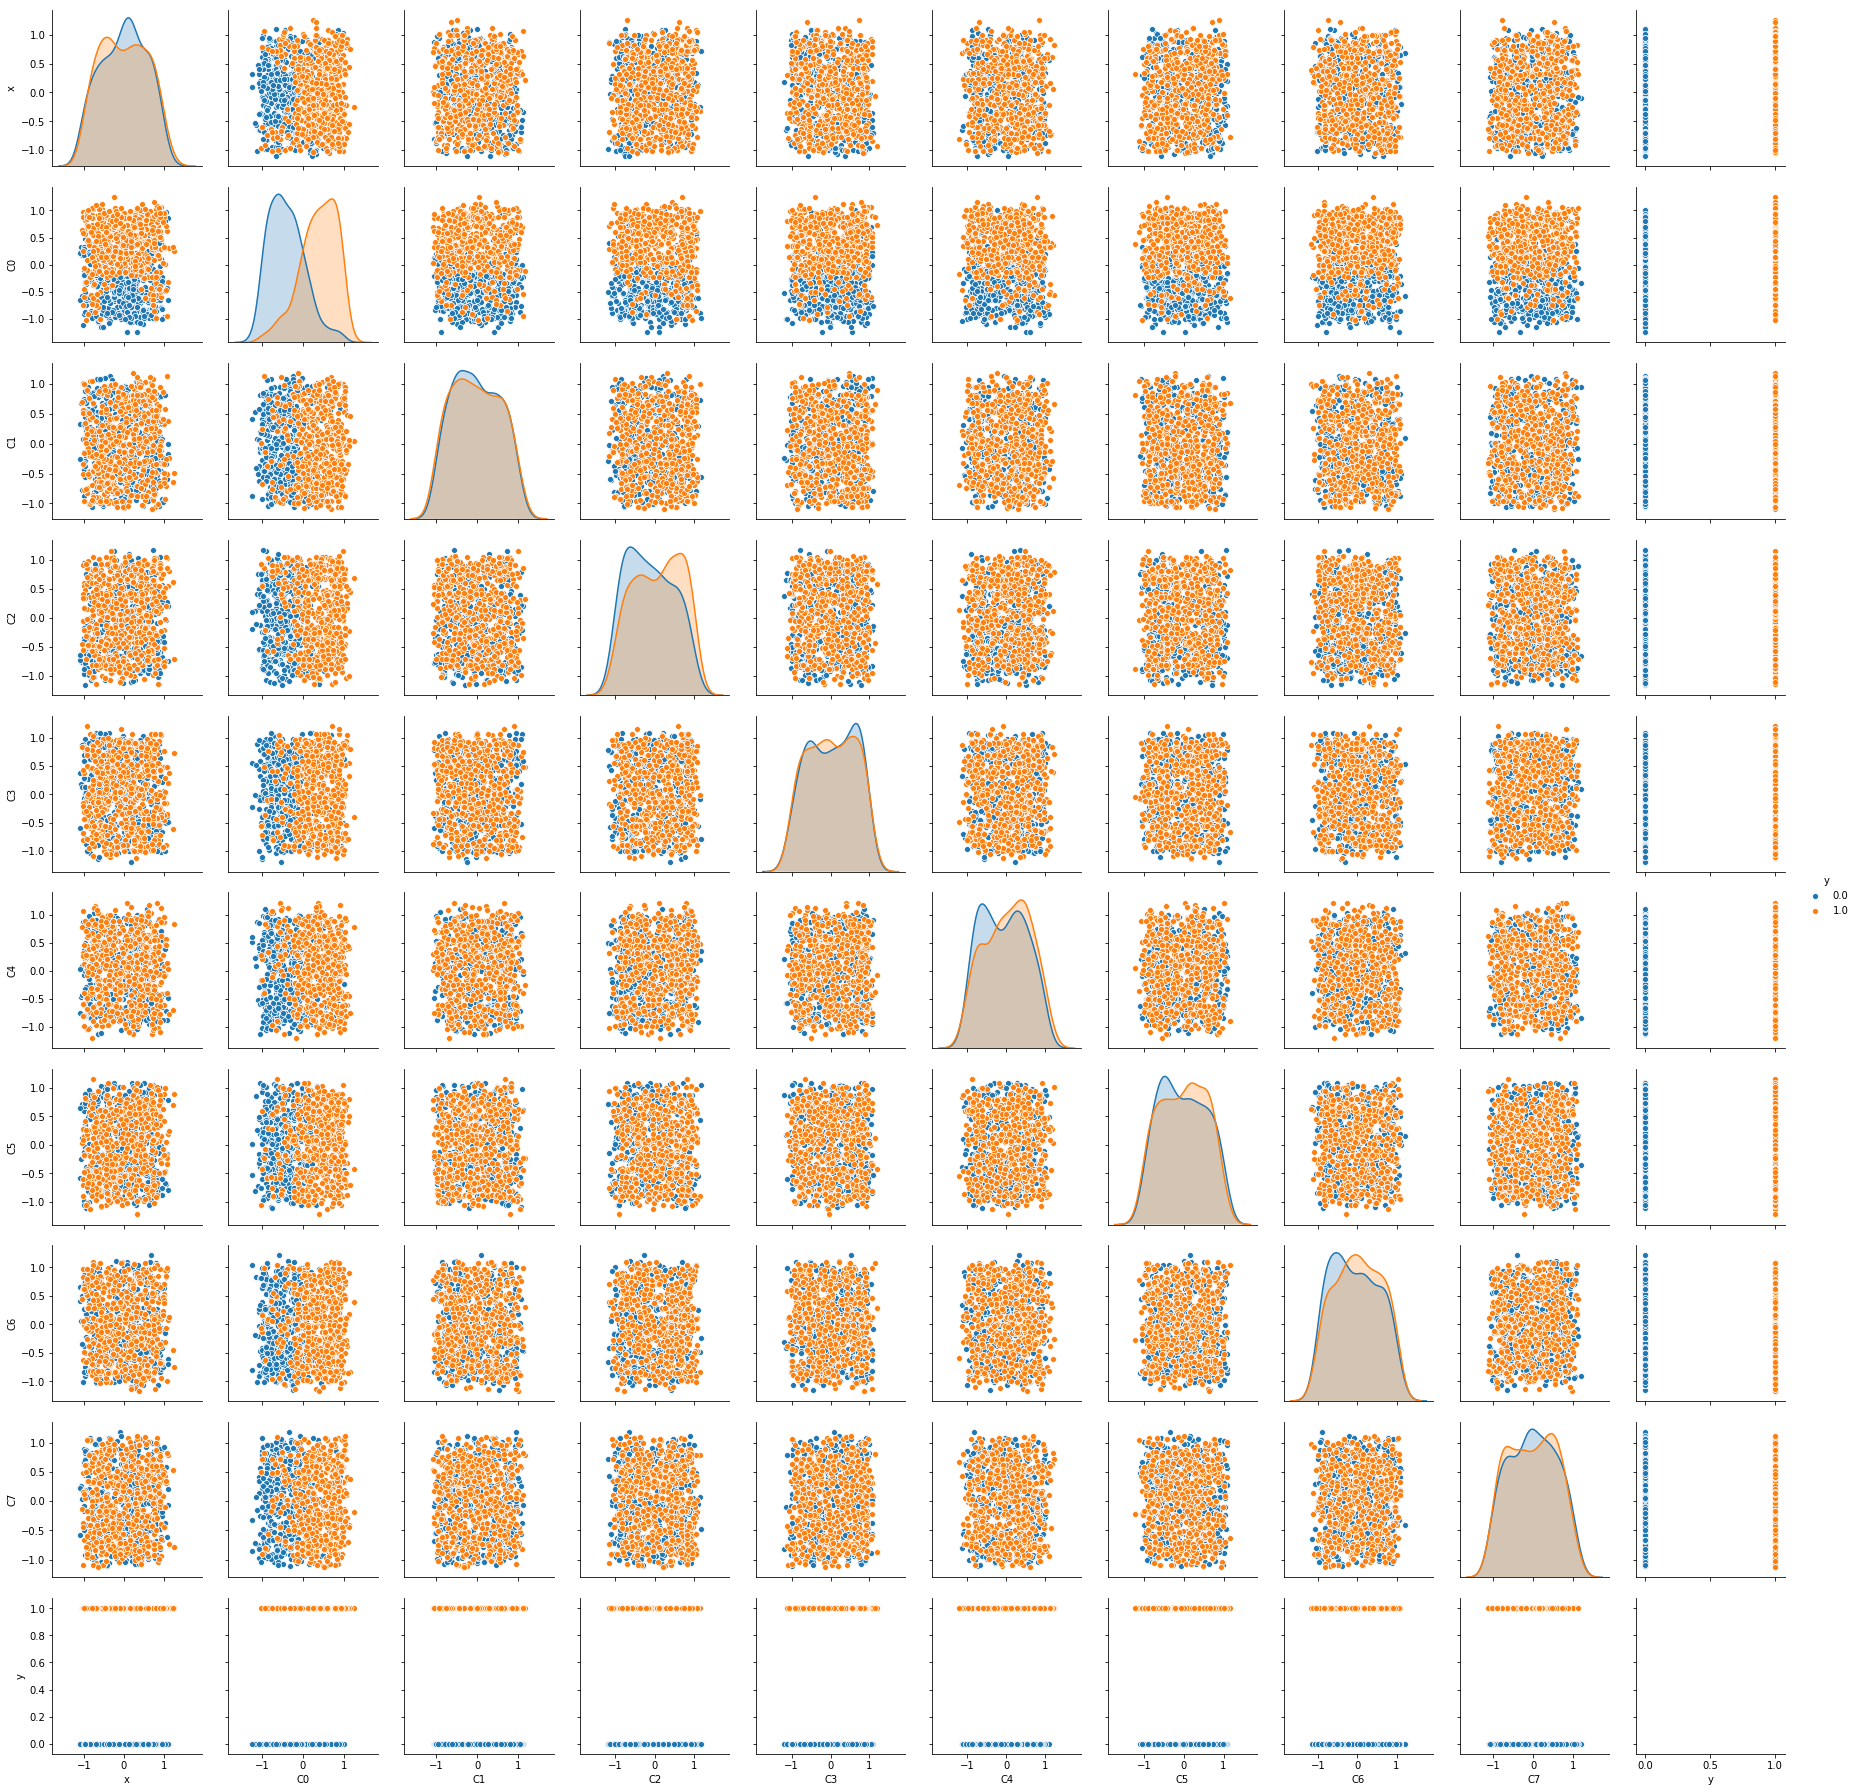

In [6]:
sns.pairplot(data, hue='y')

### Анализ выбросов

In [7]:
more = data[data.y == 1]
less = data[data.y == 0]
more.shape

(513, 10)

#### Класс 1

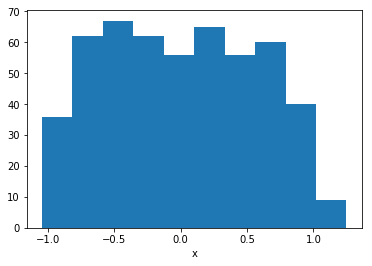

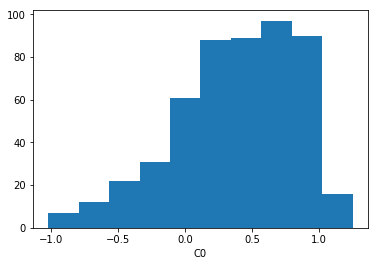

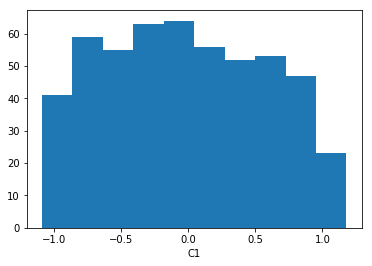

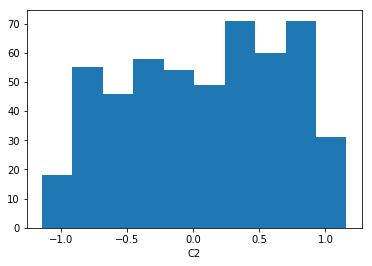

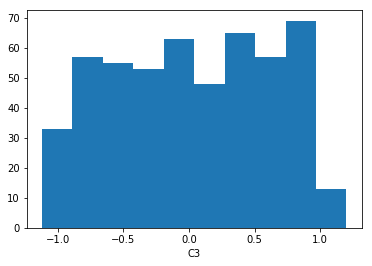

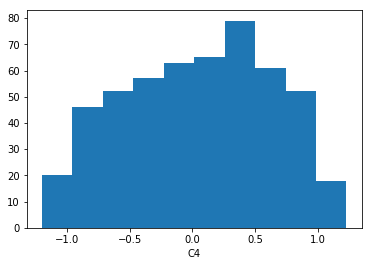

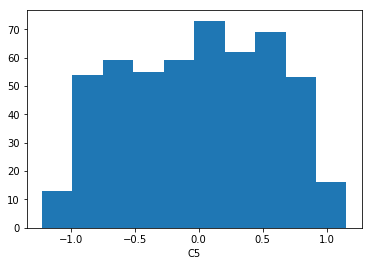

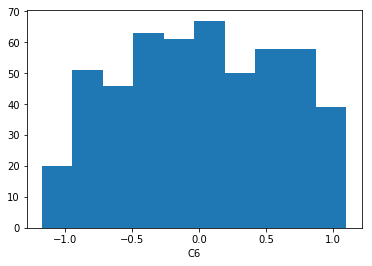

In [8]:
for i in more.columns[:8]:
    plt.hist(more[i])
    plt.xlabel(i)
    plt.show()

#### Класс 0

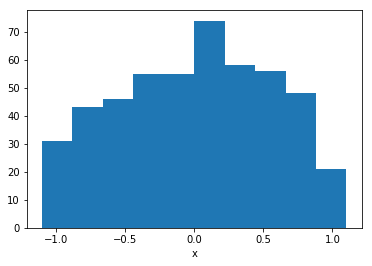

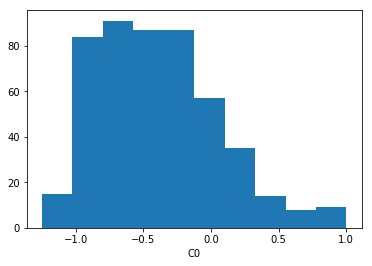

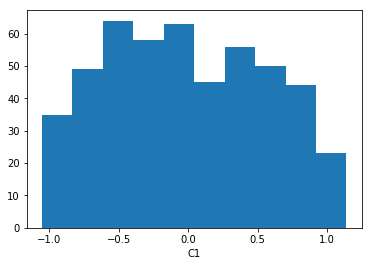

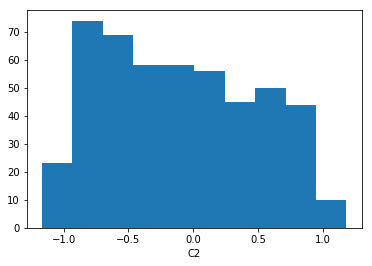

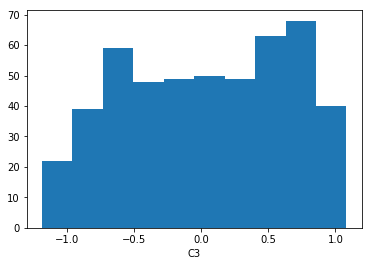

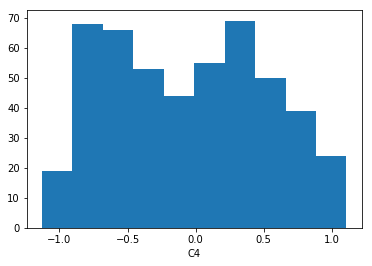

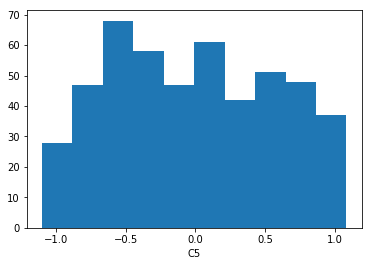

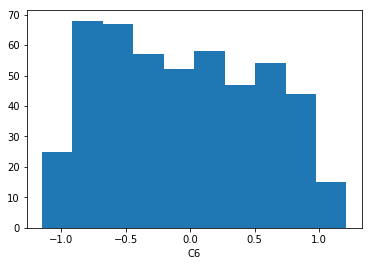

In [9]:
for i in less.columns[:8]:
    plt.hist(less[i])
    plt.xlabel(i)
    plt.show()

По гистограммам можно сделать предварительный вывод, что наибольшее влияние имеет второй признак, какие-либо выбросы отсутствуют.

### Корреляционная матрица

In [10]:
X = data.drop(['y'], axis=1)

In [11]:
X.corr()

,x,C0,C1,C2,C3,C4,C5,C6,C7
x,1.000000,0.009378,0.003249,0.043727,-0.043177,-0.043282,0.067009,-0.027484,0.026876
C0,0.009378,1.000000,-0.028072,-0.009875,0.017992,-0.019918,0.010193,0.045362,0.006195
C1,0.003249,-0.028072,1.000000,-0.058480,-0.044375,-0.002076,-0.061180,-0.021680,-0.018122
C2,0.043727,-0.009875,-0.058480,1.000000,-0.003589,0.023723,0.027159,-0.044945,-0.044220
C3,-0.043177,0.017992,-0.044375,-0.003589,1.000000,0.013230,-0.032269,-0.043834,0.025386
C4,-0.043282,-0.019918,-0.002076,0.023723,0.013230,1.000000,0.052881,-0.067532,-0.033313
C5,0.067009,0.010193,-0.061180,0.027159,-0.032269,0.052881,1.000000,-0.013316,0.009573
C6,-0.027484,0.045362,-0.021680,-0.044945,-0.043834,-0.067532,-0.013316,1.000000,0.042468
C7,0.026876,0.006195,-0.018122,-0.044220,0.025386,-0.033313,0.009573,0.042468,1.000000


Вполне ожидаемо получилось, что независимо сгенерированные случайные признаки слабо коррелируют друг с другом

## Список моделей

В данном задании для решения поставленной задачи будут использоваться следующие модели:
1. Логистическая регрессия
2. Нейронная сеть
3. Градиентный бустинг

## Критерии качества

В качестве критериев качества рассматриваются:
1. Точность
2. ROC AUC
3. PR кривая

## Разбиение выборки на обучение и контроль

Возьмем одну треть выборки под контроль, остальное для обучения, также обеспечим, чтобы в обучающей и контрольной выборках было одинаковое соотношение классов

In [12]:
y = data[['y']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.33, random_state=42, stratify=y)

## Обучение моделей и их анализ

### Логистическая регрессия

In [14]:
classifier = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
parameters_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [16]:
grid_cv = GridSearchCV(classifier, parameters_grid, scoring='accuracy', cv=cv)

In [17]:
grid_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
grid_cv.best_params_

{'C': 0.001}

In [21]:
y_predicted = grid_cv.predict(X_test)

In [22]:
best_classifier = LogisticRegression(class_weight='balanced', C=0.001)
best_classifier.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_prob = best_classifier.predict_proba(X_test)

In [24]:
metrics.accuracy_score(np.ravel(y_test), y_predicted)

0.8303030303030303

In [25]:
metrics.roc_auc_score(np.ravel(y_test), y_predicted)

0.830350251754934

In [26]:
fpr, tpr, _ = metrics.roc_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'True positive rate')

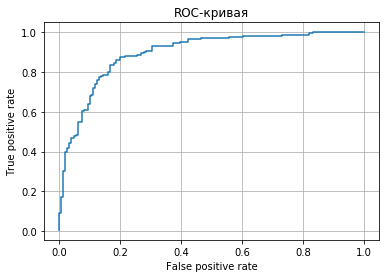

In [27]:
plt.title("ROC-кривая")
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [28]:
precision, recall, _ = metrics.precision_recall_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'Precision')

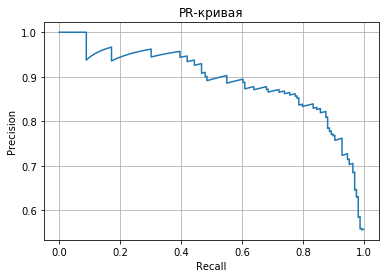

In [29]:
plt.title("PR-кривая")
plt.plot(recall, precision)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')

Зависимость точности от параметра $C$ логистической регрессии

In [30]:
acc = np.zeros(7)
for i, c in enumerate([0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    temp_classifier = LogisticRegression(class_weight='balanced', C=c)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

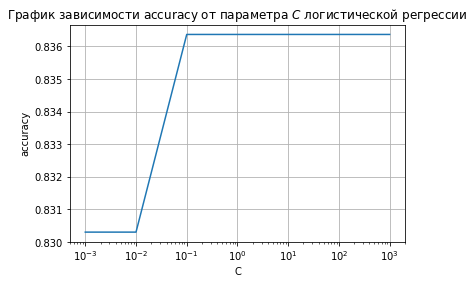

In [31]:
plt.title("График зависимости accuracy от параметра $C$ логистической регрессии")
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000], acc)
plt.grid()
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.show()

Зависимость точности от размера обучающей выборки:

In [35]:
y_train.size

670

In [38]:
temp_classifier = LogisticRegression(class_weight='balanced', C=0.001)
acc = np.zeros((y_train.size - 10, 7))
k = y_test.size // 7 + (y_test.size % 7 > 0)
for i in range(y_train.size - 10):
    temp_classifier.fit(X_train[:10 + i], np.ravel(y_train)[:10 + i])
    y_predicted = temp_classifier.predict(X_test)
    for j in range(7):
        acc[i][j] = metrics.accuracy_score((np.ravel(y_test))[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

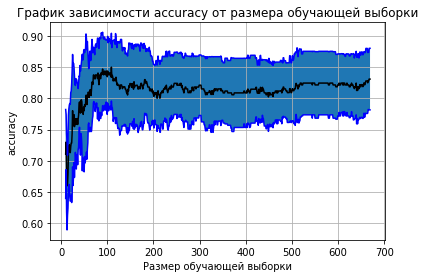

In [50]:
acc_mean = np.mean(acc, axis=1)
acc_std = np.std(acc, axis=1)
plt.title("График зависимости accuracy от размера обучающей выборки")
plt.plot(range(10, y_train.size), acc_mean, 'k-')
plt.plot(range(10, y_train.size), acc_mean - acc_std, 'b-')
plt.plot(range(10, y_train.size), acc_mean + acc_std, 'b-')
plt.fill_between(range(10, y_train.size), acc_mean - acc_std, acc_mean + acc_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("accuracy")
plt.show()

Можно заметить, что при увеличении размера выборки наблюдается тенденция к росту точности.

Зависимость точности от числа итераций оптимизационного процесса:

In [51]:
acc = np.zeros(1000)
for i in range(1000):
    temp_classifier = LogisticRegression(class_weight='balanced', C=0.001, max_iter=i)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

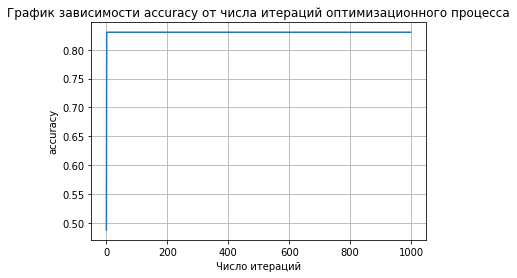

In [52]:
plt.title("График зависимости accuracy от числа итераций оптимизационного процесса")
plt.plot(range(1000), acc)
plt.grid()
plt.xlabel("Число итераций")
plt.ylabel("accuracy")
plt.show()

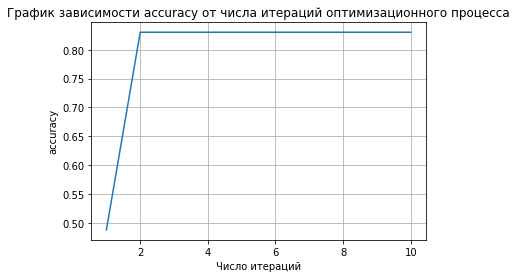

In [53]:
plt.title("График зависимости accuracy от числа итераций оптимизационного процесса")
plt.plot(range(1, 11), acc[:10])
plt.grid()
plt.xlabel("Число итераций")
plt.ylabel("accuracy")
plt.show()

Можно заметить, что оптимизационный процесс сходится уже после первой итерации

### Нейронная сеть

Возьмем обычную двухслойную нейронную сеть

In [54]:
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', X_train)
ds_train.setField('target', y_train)
ds_train._convertToOneOfMany()
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test)
ds_test._convertToOneOfMany()

In [55]:
np.random.seed(42)

net = buildNetwork(ds_train.indim, 100, ds_train.outdim, outclass=SoftmaxLayer)

init_params = np.random.random((len(net.params)))
net._setParameters(init_params)

In [56]:
random.seed(42)
trainer = BackpropTrainer(net, dataset=ds_train)
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=200)

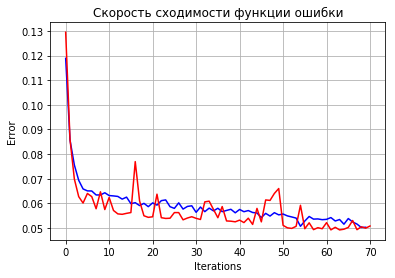

In [57]:
plt.title("Скорость сходимости функции ошибки")
plt.grid()
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

In [58]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1)
print('Error on train: ', percentError(res_train, ds_train['target'].argmax(axis=1)), '%')
res_test = net.activateOnDataset(ds_test).argmax(axis=1)
print('Error on test: ', percentError(res_test, ds_test['target'].argmax(axis=1)), '%')

Error on train:  13.73134328358209 %
Error on test:  16.060606060606062 %


In [59]:
metrics.accuracy_score(y_test, res_test)

0.8393939393939394

Определим оптимальное число нейронов внутреннего слоя

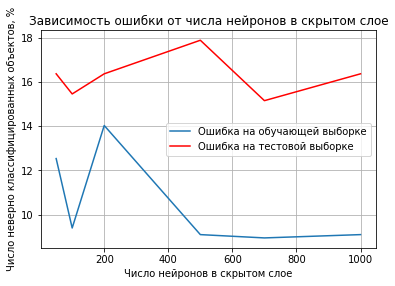

In [60]:
random.seed(42)
np.random.seed(42)

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
    plt.figure()
    plt.title('Зависимость ошибки от числа нейронов в скрытом слое')
    plt.grid()
    plt.plot(hidden_neurons_num, res_train_vec, label='Ошибка на обучающей выборке')
    plt.plot(hidden_neurons_num, res_test_vec, '-r', label='Ошибка на тестовой выборке')
    plt.legend()
    plt.xlabel('Число нейронов в скрытом слое')
    plt.ylabel('Число неверно классифицированных объектов, %')

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train)
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=200)
    res_train = net.activateOnDataset(ds_train).argmax(axis=1)
    res_test = net.activateOnDataset(ds_test).argmax(axis=1)
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1)))
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1)))
    
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)          

Делаем вывод, что оптимальное число нейронов — 700.

Построим график зависимости ошибки от числа объектов в обучающей выборке

In [61]:
random.seed(42)
np.random.seed(42)

tr_sizes = [100, 200, 300, 400, 500, 600]
res_test_vec = np.zeros((6, 7))

for i, tr in enumerate(tr_sizes):
    ds_train = ClassificationDataSet(tr, nb_classes=len(np.unique(y_train)))
    ds_train.setField('input', X_train[:tr])
    ds_train.setField('target', y_train[:tr])
    ds_train._convertToOneOfMany( )
    net = buildNetwork(ds_train.indim, 700, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train)
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=100)
    for j in range(7):
        ds_test = ClassificationDataSet(np.shape(X[k * j: k * (j + 1)])[1], nb_classes=len(np.unique(y_train)))
        ds_test.setField('input', X_test[k * j: k * (j + 1)])
        ds_test.setField('target', y_test[k * j: k * (j + 1)])
        ds_test._convertToOneOfMany()
        res_test = net.activateOnDataset(ds_test).argmax(axis=1)
        res_test_vec[i][j] = percentError(res_test, ds_test['target'].argmax(axis=1))

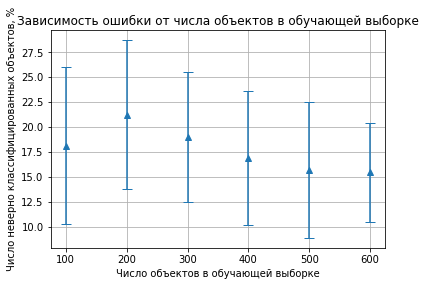

In [74]:
res_test_mean = np.mean(res_test_vec, axis = 1)
res_test_std = np.std(res_test_vec, axis = 1)
plt.title('Зависимость ошибки от числа объектов в обучающей выборке')
plt.errorbar(tr_sizes, res_test_mean, res_test_std, linestyle=' ', marker='^', capsize=5, label='Ошибка на тестовой выборке')
plt.grid()
plt.xlabel('Число объектов в обучающей выборке')
plt.ylabel('Число неверно классифицированных объектов, %')
plt.show()

### Градиентный бустинг

In [75]:
xg = xgb.XGBClassifier()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.33, random_state=42, stratify=y)

In [77]:
parameters_grid = {
    'learning_rate' : [0.1, 0.3, 0.4, 0.5, 0.6, 0.7],
    'max_depth' : [3, 5, 7, 9, 11, 13],
    'n_estimators' : [30, 40, 50, 60, 100, 200, 300, 400]
}

In [78]:
grid_cv = GridSearchCV(xg, parameters_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid_cv.fit(X_train, np.ravel(y_train))
print('best_score', grid_cv.best_score_)
print('best_params', grid_cv.best_params_)

best_score 0.8492537313432836
best_params {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 30}


In [80]:
best_classifier = xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=30)
best_classifier.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [81]:
y_predicted = grid_cv.predict(X_test)
y_prob = best_classifier.predict_proba(X_test)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [82]:
metrics.accuracy_score(np.ravel(y_test), y_predicted)

0.8545454545454545

In [83]:
metrics.roc_auc_score(np.ravel(y_test), y_predicted)

0.8544599213495535

In [84]:
fpr, tpr, _ = metrics.roc_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'True positive rate')

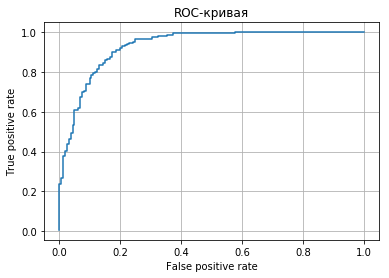

In [85]:
plt.title("ROC-кривая")
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [86]:
precision, recall, _ = metrics.precision_recall_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'Precision')

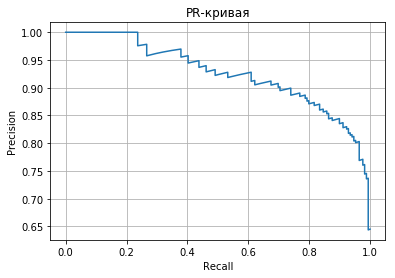

In [87]:
plt.title("PR-кривая")
plt.plot(recall, precision)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')

Зависимость точности от параметров модели

In [94]:
acc = np.zeros(6)
for i, learn in enumerate([0.1, 0.3, 0.4, 0.5, 0.6, 0.7]):
    temp_classifier = xgb.XGBClassifier(learning_rate=learn, max_depth=5, n_estimators=30)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

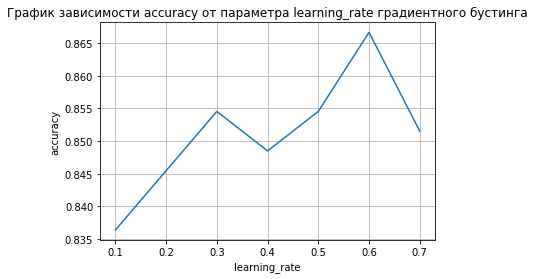

In [95]:
plt.title("График зависимости accuracy от параметра learning_rate градиентного бустинга")
plt.plot([0.1, 0.3, 0.4, 0.5, 0.6, 0.7], acc)
plt.grid()
plt.xlabel("learning_rate")
plt.ylabel("accuracy")
plt.show()

In [96]:
acc = np.zeros(6)
for i, depth in enumerate([3, 5, 7, 9, 11, 13]):
    temp_classifier = xgb.XGBClassifier(learning_rate=0.3, max_depth=depth, n_estimators=30)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

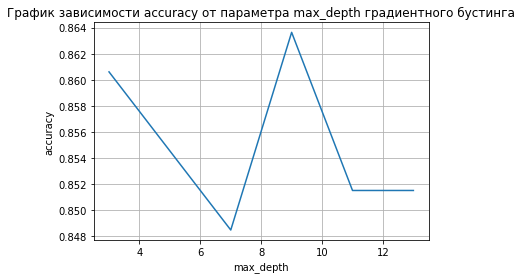

In [97]:
plt.title("График зависимости accuracy от параметра max_depth градиентного бустинга")
plt.plot([3, 5, 7, 9, 11, 13], acc)
plt.grid()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

In [98]:
acc = np.zeros(8)
for i, est in enumerate([30, 40, 50, 60, 100, 200, 300, 400]):
    temp_classifier = xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=est)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

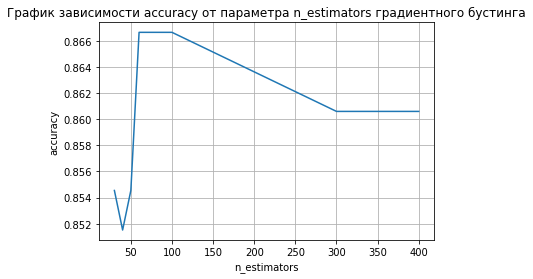

In [99]:
plt.title("График зависимости accuracy от параметра n_estimators градиентного бустинга")
plt.plot([30, 40, 50, 60, 100, 200, 300, 400], acc)
plt.grid()
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

In [102]:
temp_classifier = xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=30)
acc = np.zeros((y_train.size - 10, 7))
k = y_test.size // 7 + (y_test.size % 7 > 0)
for i in range(y_train.size - 10):
    temp_classifier.fit(X_train[:10 + i], np.ravel(y_train)[:10 + i])
    y_predicted = temp_classifier.predict(X_test)
    for j in range(7):
        acc[i][j] = metrics.accuracy_score((np.ravel(y_test))[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

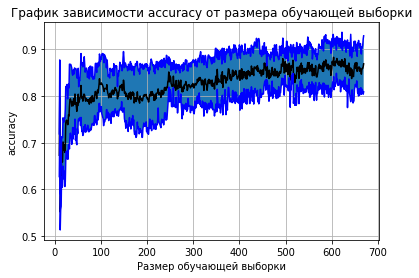

In [103]:
acc_mean = np.mean(acc, axis=1)
acc_std = np.std(acc, axis=1)
plt.title("График зависимости accuracy от размера обучающей выборки")
plt.plot(range(10, y_train.size), acc_mean, 'k-')
plt.plot(range(10, y_train.size), acc_mean - acc_std, 'b-')
plt.plot(range(10, y_train.size), acc_mean + acc_std, 'b-')
plt.fill_between(range(10, y_train.size), acc_mean - acc_std, acc_mean + acc_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("accuracy")
plt.show()